In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np
db=mysql.connector.connect(    
    host='localhost',
    user='root',
    password='MYsql@5#*mysql',
    database='ecommerce'
)
cur = db.cursor()



# 1.List all unique cities where customers are located 


In [22]:
query="select distinct customer_city from customers"
cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [6]:
query="select count(order_id) from orders where year(order_purchase_timestamp)=2017 "
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 90202)

# 3. Find the total sales per category.

In [12]:
query="""select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [14]:
query="""select sum(case when payment_installments >= 1 then 1
else 0 end)/count(*)*100
from payments"""
cur.execute(query)
data=cur.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# 5. Count the number of customers from each state. 

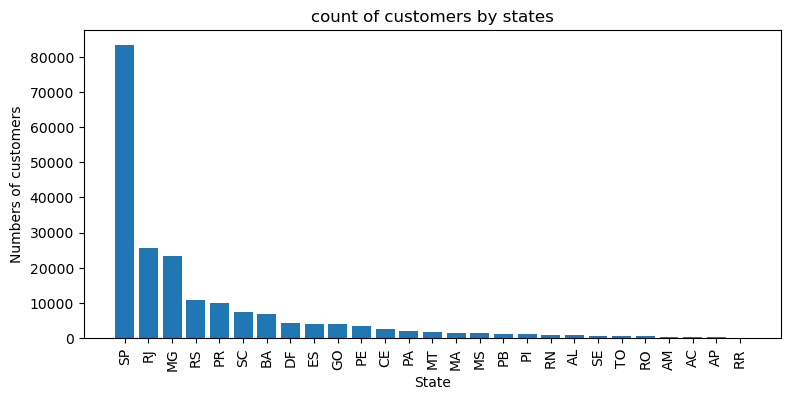

In [35]:
query="""select customer_state, count(customer_id)
from customers
group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["State", "Numbers of customers"])
df=df.sort_values(by="Numbers of customers", ascending=False)
plt.figure(figsize=(9,4))
plt.bar(df["State"], df["Numbers of customers"])
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Numbers of customers")
plt.title("count of customers by states")
plt.show()

# 6. Calculate the number of orders per month in 2018.

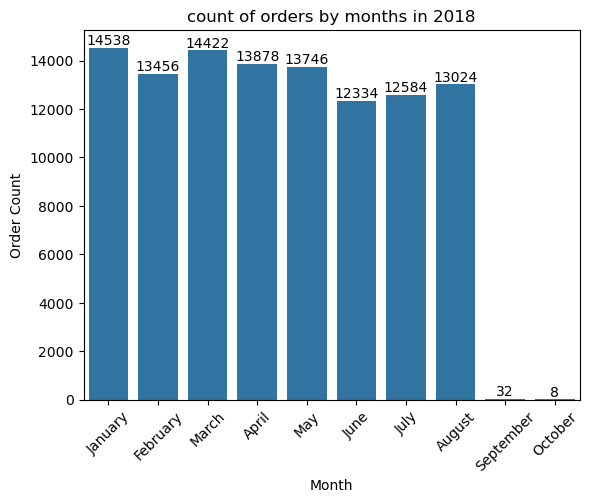

In [45]:
query="""select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders
where year(order_purchase_timestamp)=2018
group by  months"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Month", "Order Count"])
o=["January", "February", "March","April","May","June","July","August","September","October"]
ax=sns.barplot(x=df["Month"],y=df["Order Count"], data=df, order=o ) #color= "pink" )#hue= df["Month"], palette="viridis")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("count of orders by months in 2018")
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [59]:
query="""with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city
order by average_orders desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=[" customer city", "average products per orders"])
df.head(10)

,customer city,average products per orders
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [85]:
query="""select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
order by sales desc"""
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=[" Product Category", "Sales Percentage"])
df.head(10)

,Product Category,Sales Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [67]:
query="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id= order_items.product_id
group by products.product_category;
"""
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=[" Product Category", "Product Count", "Product Price"])

arr1=df["Product Count"]
arr2=df["Product Price"]

a=np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased is", a[0][-1])

the correlation between product price and the number of times a product has been purchased is -0.10631514167157562


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

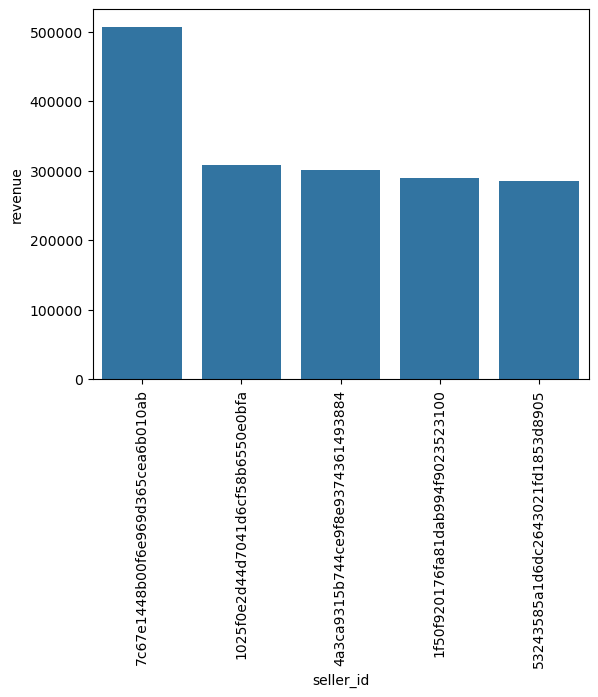

In [92]:
query="""select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id= payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=["seller_id", "revenue", "Rank of Seller"])
df= df.head()
sns.barplot(x="seller_id", y = "revenue", data = df)
plt.xticks(rotation= 90)
plt.show()


# 11. Calculate the moving average of order values for each customer over their order history.

In [103]:
query="""select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id= orders.order_id) as a;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["customer_id", "order_purchase_timestamp", "payment", "average"])
df.head(10)

,customer_id,order_purchase_timestamp,payment,average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
5,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
6,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
7,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
8,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
9,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# 12. Calculate the cumulative sales per month for each year.

In [116]:
query="""select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id=payments.order_id
group by years, months order by years, months) as a;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Year", "Month", "Payment", "Cumulative Sales"])
df

,Year,Month,Payment,Cumulative Sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


# 13. Calculate the year-over-year growth rate of total sales.

In [128]:
query="""with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id=payments.order_id
group by years order by years)

select years,((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 previous_year from a
;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Year", "YOY  %Growth "])
df

# year over year formula:-
# ((current_sales - prevoius_year_sale)/prevoius_year_sale)*100


,Year,YOY %Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [132]:
query="""with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id= a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id;
"""
cur.execute(query)
data=cur.fetchall()
# df=pd.DataFrame(data, columns=["Year", "YOY  %Growth "])
data

[(None,)]

# 15. Identify the top 3 customers who spent the most money in each year.

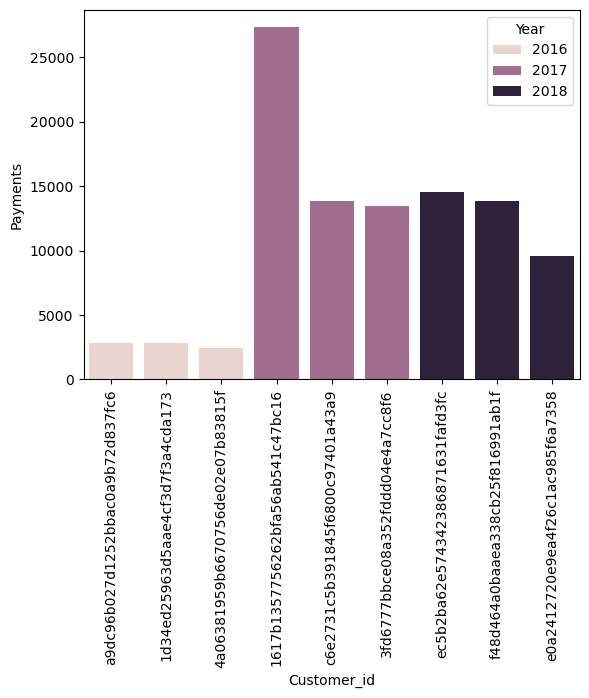

In [152]:
query="""select years,customer_id,payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank<=3;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Year", "Customer_id", "Payments", "Rank"])
sns.barplot(x="Customer_id", y="Payments", data=df, hue="Year")
plt.xticks(rotation=90)
plt.show()